<a href="https://colab.research.google.com/github/ChhaviC/comp3132/blob/main/LabWeek12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab Week 12 - Transfer Learning: Using a pretrained model

## Tranfer learning

Usually we use a combination of a convolutional network that extracts abstract features from the image and a fully connected part (often called "top") that uses those features for classification.

![](https://www.mcpressonline.com/images/thumbnails/thumb_20230621SandersFig2.JPG)


## ImageNet
ImageNet is a large dataset of over 14 million labeled images organized according to the WordNet hierarchy. It's a crucial resource for training and evaluating computer vision models, particularly deep learning models. By providing a standardized dataset with high-quality annotations, ImageNet has significantly accelerated progress in image classification, object detection, and other vision tasks.

https://en.wikipedia.org/wiki/ImageNet

![](https://blog.roboflow.com/content/images/size/w1000/2021/06/image-18.png)

## VGG Net
[VGG16](https://en.wikipedia.org/wiki/VGGNet), published in 2014, achieved top ranks in a competition for classifying ImageNet images into 1000 categories.

Architecture of VGG16:

![](https://media.geeksforgeeks.org/wp-content/uploads/20200219152207/new41.jpg)

## Reusing pre-trained networks
Trainig a fairly large network like VGG16 on the 14 million images from ImageNet takes considerable time and resources but results in a CNN that can reliably recognize a large set of features in any image. It is very useful to utilize this pre-trained network for feature detection in any images that might resemble those from ImageNet and then train a new fully connected network to classify the images using these features.


![](https://dev-to-uploads.s3.amazonaws.com/i/2oyycxxs02jmcghplwc4.png)




## Setp 1: Loading the data - same as last week

We will be using the same cats and dogs dataset from the last week, but downloded in simpler way.

In [ ]:
## Download a zip with a subset of the cats and dogs from Gootl Drive
!gdown 1HxDoufgbF11R_xPfFmdXLnfztPXYaKiS

Downloading...
From (original): https://drive.google.com/uc?id=1HxDoufgbF11R_xPfFmdXLnfztPXYaKiS
From (redirected): https://drive.google.com/uc?id=1HxDoufgbF11R_xPfFmdXLnfztPXYaKiS&confirm=t&uuid=703152f5-92c9-4ddb-bbbb-50e55befacfd
To: /content/catsVdogs_small.zip
100% 114M/114M [00:01<00:00, 83.6MB/s]


In [ ]:
!unzip -o -q catsVdogs_small.zip

### Data preprocessing (For this section just run the cells)

**Copying images to training, validation, and test directories**

In [ ]:
# imports and setup

import numpy as np
import matplotlib.pylab as plt

import os, shutil, pathlib

import keras
from keras import layers
from tensorflow.keras.utils import image_dataset_from_directory

new_base_dir = pathlib.Path('small')


**Using `image_dataset_from_directory` to read images**

In [ ]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


### Displaying the the data and labels yielded by the `Dataset`

`train_dataset`, `validation_dataset`, and `test_dataset` behave like a **generator** in the sense that it **yields data lazily** when iterated over, instead of loading everything into memory at once.

**TODO: Iterate over `train_dataset` and take one sample batch and labels, print the shape of the batch and save it in `sample_batch` variable**

In [ ]:
#your code
# Take one batch from train_dataset
for images, labels in train_dataset.take(1):
    sample_batch = images
    print("Batch shape:", images.shape)
    print("Labels shape:", labels.shape)
    break


Batch shape: (32, 180, 180, 3)
Labels shape: (32,)


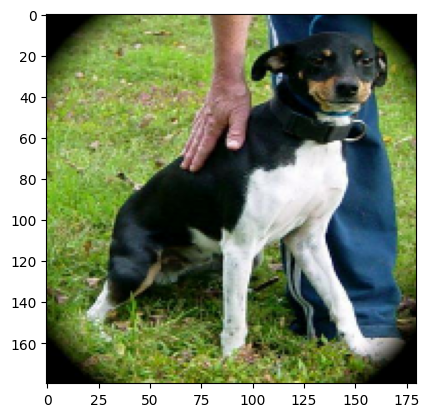

In [ ]:
import matplotlib.pylab as plt
plt.imshow(sample_batch[10].numpy().astype("uint8"))

**TODO: What is the shape of your image?**

In [8]:
#your code here
# Get the shape of a single image from the batch
print("shape of a single image:", sample_batch[0].shape)


shape of a single image: (180, 180, 3)


## Step 2: Load the pretrained VGG16 model from Keras

**Instantiating the VGG16 convolutional base**

In [9]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 180, 180, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 90, 90, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 45, 45, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 22, 22, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 5, 5, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

## Step 3:  Feature extraction with a pretrained model

**Extracting the VGG16 features and corresponding labels**

In [11]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

**TODO:Explore the shape and size of the extracted features**

In [12]:
#your code here
# Use the pretrained VGG16 conv_base to extract features from the sample batch
extracted_features = conv_base(sample_batch)

# Print the shape of the extracted features
print("Extracted feature shape:", extracted_features.shape)


Extracted feature shape: (32, 5, 5, 512)


## Step 4- Pipeline A:
## Definine and train the densely connected classifier that uses the extracted features as input

**TODO: Define and compile the model to classify pictures as cats vs dogs**
- What will be the size of the output layer?
- What activation function should the output layer use?
- What loss function should be used?
- Layers to use
  - `Input` layer and pass the shape of the features e.g. `shape=(5, 5, 512)`
  - `Flatten` as the first layer to reshape the feature maps returned by the CSS into 1-D arrays
  - `Dense` layer with 128 neurons
  - `Dropout` layer with 30% to 50% dropout rate
  - `Output` layer
- Don't forget to add `accuracy` metric when compiling the model
- You can use either `Sequential` or functional API to define the model

In [14]:
# your code here
from tensorflow import keras
from tensorflow.keras import layers

# Input layer matching the shape of extracted features
inputs = keras.Input(shape=(5, 5, 512))

# Flatten feature maps into 1D
x = layers.Flatten()(inputs)

# Dense layer
x = layers.Dense(128, activation='relu')(x)

# Dropout layer
x = layers.Dropout(0.5)(x)  # You can use 0.3 or 0.5

# Output layer for binary classification
outputs = layers.Dense(1, activation='sigmoid')(x)

# Create the model
model = keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Optional: view model structure
model.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 5, 5, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       1,638,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,638,657 (6.25 MB)

 Trainable params: 1,638,657 (6.25 MB)

 Non-trainable params: 0 (0.00 B)

**Plotting the results**

**TODO: Plot the history of loss and accuracty as we did in the previous labs**

In [18]:
# Train your model and store the result in `history`
history = model.fit(
    train_features,  # or train_dataset if you're using images directly
    train_labels,
    epochs=10,
    validation_data=(val_features, val_labels)  # or validation_dataset
)


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.8792 - loss: 2.7262 - val_accuracy: 0.9730 - val_loss: 0.2147
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9736 - loss: 0.2247 - val_accuracy: 0.9630 - val_loss: 0.2496
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9846 - loss: 0.0954 - val_accuracy: 0.9730 - val_loss: 0.1161
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9894 - loss: 0.0461 - val_accuracy: 0.9800 - val_loss: 0.1473
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9914 - loss: 0.0464 - val_accuracy: 0.9750 - val_loss: 0.1478
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9901 - loss: 0.0223 - val_accuracy: 0.9750 - val_loss: 0.1381
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9897 - loss: 0.0603 - val_accuracy: 0.9730 - val_loss: 0.2097
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9895 - loss: 0.0743 - val_accuracy: 0.9720 - val_loss

Available keys in history: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


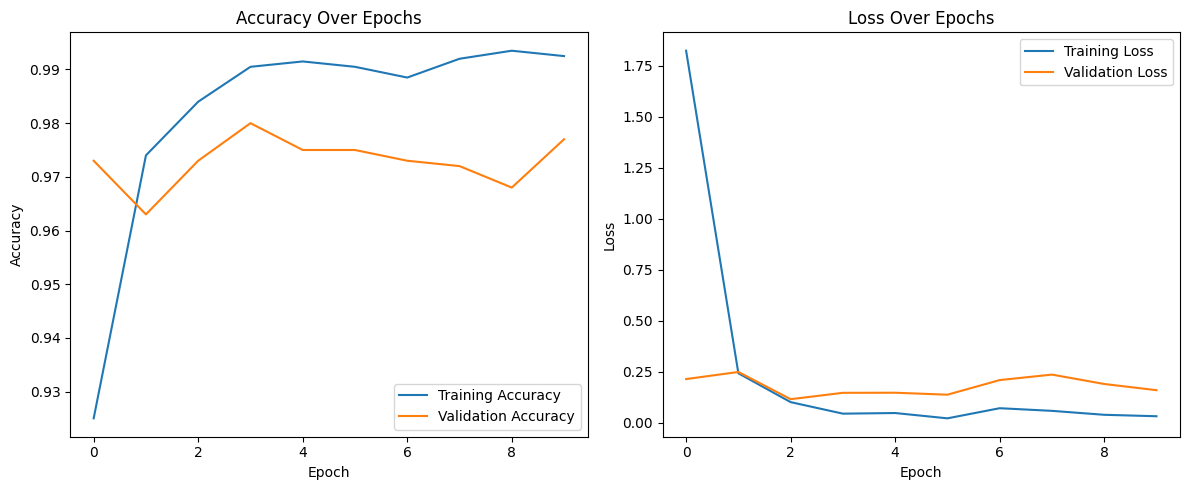

In [19]:
import matplotlib.pyplot as plt

# Check available metrics
print("Available keys in history:", history.history.keys())

# Plot accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
if "accuracy" in history.history:
    plt.plot(history.history["accuracy"], label="Training Accuracy")
if "val_accuracy" in history.history:
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss")
if "val_loss" in history.history:
    plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


**Evaluate the model using test data**

In [22]:
#your code here
# Evaluate the model using test features and labels
test_loss, test_acc = model.evaluate(test_features, test_labels)

print(f"Test Accuracy: {test_acc:.4f}")
print(f" Test Loss: {test_loss:.4f}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9817 - loss: 0.1254
Test Accuracy: 0.9765
 Test Loss: 0.1656


## Step 4- Pipeline B:
## Feature extraction together with classifier in a single architecture

**Instantiating and freezing the VGG16 convolutional base**

In [23]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False) ## this means we only get the convolutional part without the densely connected top


conv_base.trainable = False ## This freezes the wieghts on the convolutional part

**Printing the list of trainable weights before and after freezing**

In [24]:
conv_base.trainable = True
print("This is the number of trainable weight tensors "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weight tensors before freezing the conv base: 26


**In order to calculate the number of trainable parameters we need to add up the size of each tensor. try running this with the layers fronzen and unfrozen and compare to the number returned by `conv_base.summary()`**

In [25]:
trainable_params = 0
for layer in conv_base.trainable_weights:
  trainable_params += layer.numpy().size

print(f'Number of trainable parameters is {trainable_params}')


Number of trainable parameters is 14714688


In [26]:
conv_base.trainable = False
print("This is the number of trainable weight tensors "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weight tensors after freezing the conv base: 0


**Frozen ConvNet and densely connected network in a single architecture**

In [27]:
inputs = keras.Input(shape=(180, 180, 3))
x = keras.applications.vgg16.preprocess_input(inputs)

x = conv_base(x) # Convolutional base

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model2 = keras.Model(inputs, outputs)
model2.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [28]:
model2.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 180, 180, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 180, 180)       │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 180, 180)       │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 180, 180)       │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack (Stack)             │ (None, 180, 180, 3)    │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_1[0][0],      │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 180, 180, 3)    │              0 │ stack[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 5, 5, 512)      │     14,714,688 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 12800)          │              0 │ vgg16[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 256)            │      3,277,056 │ flatten_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 256)            │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 1)              │            257 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 17,992,001 (68.63 MB)

 Trainable params: 3,277,313 (12.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

**This model (Pipeline B) is exactly the same as what you did for Pipeline A.**

**TODO: Train `model2`, evaluate the trained model, and plot the results.**

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 321ms/step - accuracy: 0.8679 - loss: 42.8346 - val_accuracy: 0.9560 - val_loss: 9.2601
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 33s 218ms/step - accuracy: 0.9816 - loss: 3.8279 - val_accuracy: 0.9690 - val_loss: 5.0120
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 211ms/step - accuracy: 0.9866 - loss: 1.4604 - val_accuracy: 0.9760 - val_loss: 3.2596
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 223ms/step - accuracy: 0.9886 - loss: 2.5315 - val_accuracy: 0.9770 - val_loss: 3.8058
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 224ms/step - accuracy: 0.9989 - loss: 0.1346 - val_accuracy: 0.9770 - val_loss: 3.9607
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 214ms/step - accuracy: 0.9960 - loss: 0.3448 - val_accuracy: 0.9740 - val_loss: 5.3474
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - accuracy: 0.9969 - loss: 0.2684 - val_accuracy: 0.9760 - val_loss: 5.1406
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 223ms/step - accuracy: 0.9970 - loss: 0.2519 - val_acc

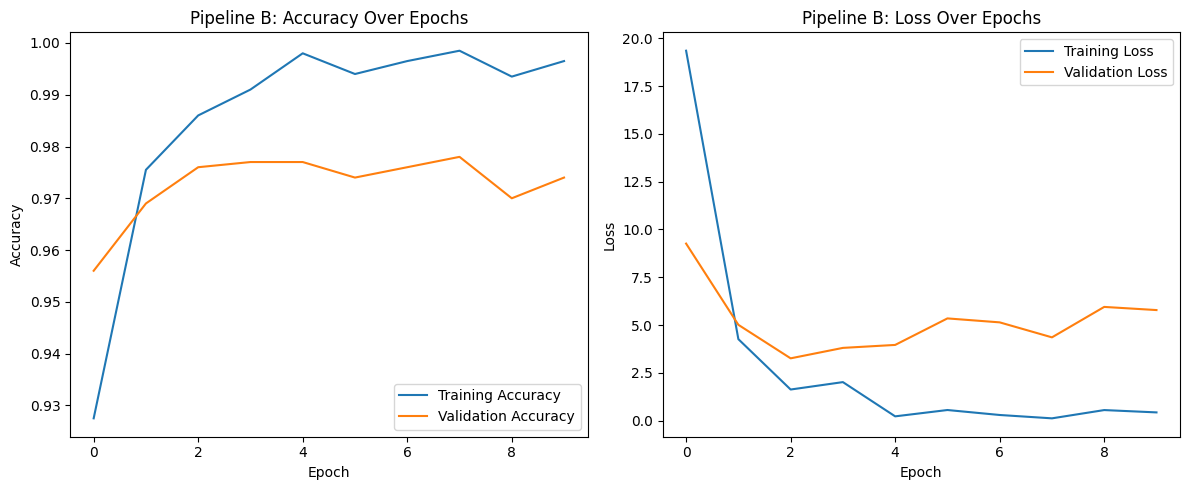

In [29]:
#your code here
# 1. Train model2
history2 = model2.fit(
    train_dataset,
    epochs=10,  # You can increase to 20–30 if needed
    validation_data=validation_dataset
)

# 2. Evaluate the trained model on test data
test_loss, test_acc = model2.evaluate(test_dataset)
print(f" Pipeline B - Test Accuracy: {test_acc:.4f}")
print(f" Pipeline B - Test Loss: {test_loss:.4f}")

# 3. Plot training/validation accuracy and loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history2.history["accuracy"], label="Training Accuracy")
plt.plot(history2.history["val_accuracy"], label="Validation Accuracy")
plt.title("Pipeline B: Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history2.history["loss"], label="Training Loss")
plt.plot(history2.history["val_loss"], label="Validation Loss")
plt.title("Pipeline B: Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()
